# Tutorial: Modern Pandas - Method Chaining (Part 2)
This tutorial can be accessed [here](http://tomaugspurger.github.io/method-chaining).

Method chaining, where you call methods on an object one after another, is in vogue at the moment. It's always been a style of programming that's been possible with pandas, and over the past several releases, we've added methods that enable even more chaining.

* [assign](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.assign.html) (0.16.0): For adding new columns to a DataFrame in a chain (inspired by dplyr's mutate)
* [pipe](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.pipe.html) (0.16.2): For including user-defined methods in method chains.
* [rename](http://pandas.pydata.org/pandas-docs/version/0.18.0/whatsnew.html#changes-to-rename) (0.18.0): For altering axis names (in additional to changing the actual labels as before).
* [Window methods](http://pandas.pydata.org/pandas-docs/version/0.18.0/whatsnew.html#window-functions-are-now-methods) (0.18): Took the top-level pd.rolling_* and pd.expanding_* functions and made them NDFrame methods with a groupby-like API.
* [Resample](http://pandas.pydata.org/pandas-docs/version/0.18.0/whatsnew.html#resample-api) (0.18.0) Added a new groupby-like API
* [.where/mask/Indexers accept Callables](https://github.com/pandas-dev/pandas/pull/12539) (0.18.1): In the next release you'll be able to pass a callable to the indexing methods, to be evaluated within the DataFrame's context (like .query, but with code instead of strings).

My scripts will typically start off with large-ish chain at the start getting things into a manageable state. It's good to have the bulk of your munging done with right away so you can start to do Science™:

Here's a quick example:

## Libraries

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='ticks', context='talk')

## Configurations

In [4]:
%matplotlib inline

## Data

In [8]:
def read(fp):
    df = (pd.read_csv(fp)
            .rename(columns=str.lower)
            .pipe(extract_city_name)
            .pipe(time_to_datetime, ['dep_time', 'arr_time', 'crs_arr_time', 'crs_dep_time'])
            .assign(fl_date=lambda x: pd.to_datetime(x['fl_date']),
                    dest=lambda x: pd.Categorical(x['dest']),
                    origin=lambda x: pd.Categorical(x['origin']),
                    tail_num=lambda x: pd.Categorical(x['tail_num']),
                    unique_carrier=lambda x: pd.Categorical(x['unique_carrier']),
                    cancellation_code=lambda x: pd.Categorical(x['cancellation_code'])))
    return df

def extract_city_name(df):
    '''
    Chicago, IL -> Chicago for origin_city_name and dest_city_name
    '''
    cols = ['origin_city_name', 'dest_city_name']
    city = df[cols].apply(lambda x: x.str.extract("(.*), \w{2}", expand=False))
    df = df.copy()
    df[['origin_city_name', 'dest_city_name']] = city
    return df

def time_to_datetime(df, columns):
    '''
    Combine all time items into datetimes.

    2014-01-01,0914 -> 2014-01-01 09:14:00
    '''
    df = df.copy()
    def converter(col):
        timepart = (col.astype(str)
                       .str.replace('\.0$', '')  # NaNs force float dtype
                       .str.pad(4, fillchar='0'))
        return pd.to_datetime(df['fl_date'] + ' ' +
                               timepart.str.slice(0, 2) + ':' +
                               timepart.str.slice(2, 4),
                               errors='coerce')
    df[columns] = df[columns].apply(converter)
    return df

output = 'data/flights.h5'

if not os.path.exists(output):
    df = read("data/826783186_T_ONTIME.csv")
    df.to_hdf(output, 'flights', format='table')
else:
    df = pd.read_hdf(output, 'flights', format='table')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450017 entries, 0 to 450016
Data columns (total 33 columns):
fl_date                  450017 non-null datetime64[ns]
unique_carrier           450017 non-null category
airline_id               450017 non-null int64
tail_num                 449378 non-null category
fl_num                   450017 non-null int64
origin_airport_id        450017 non-null int64
origin_airport_seq_id    450017 non-null int64
origin_city_market_id    450017 non-null int64
origin                   450017 non-null category
origin_city_name         450017 non-null object
dest_airport_id          450017 non-null int64
dest_airport_seq_id      450017 non-null int64
dest_city_market_id      450017 non-null int64
dest                     450017 non-null category
dest_city_name           450017 non-null object
crs_dep_time             450017 non-null datetime64[ns]
dep_time                 441445 non-null datetime64[ns]
dep_delay                441476 non-null float64


I find method chains readable, though some people don't. Both the code and the flow of execution are from top to bottom, and the function parameters are always near the function itself, unlike with heavily nested function calls.

My favorite example demonstrating this comes from Jeff Allen (pdf). Compare these two ways of telling the same story:

`tumble_after(
    broke(
        fell_down(
            fetch(went_up(jack_jill, "hill"), "water"),
            jack),
        "crown"),
    "jill"
)
`

and

`jack_jill %>%
    went_up("hill") %>%
    fetch("water") %>%
    fell_down("jack") %>%
    broke("crown") %>%
    tumble_after("jill")
`

Even if you weren't aware that in R `%>%` (pronounced pipe) calls the function on the right with the thing on the left as an argument, you can still make out what's going on. Compare that with the first style, where you need to unravel the code to figure out the order of execution and which arguments are being passed where.

Admittedly, you probably wouldn't write the first one. It'd be something like:

`on_hill = went_up(jack_jill, 'hill')
with_water = fetch(on_hill, 'water')
fallen = fell_down(with_water, 'jack')
broken = broke(fallen, 'jack')
after = tmple_after(broken, 'jill')`

I don't like this version because I have to spend time coming up with appropriate names for variables. That's bothersome when we don't really care about the `on_hill` variable. We're just passing it into the next step.

A fourth way of writing the same story may be available. Suppose you owned a JackAndJill object, and could define the methods on it. Then you'd have something like R's `%>%` example.

`
jack_jill = JackAndJill()
(jack_jill.went_up('hill')
    .fetch('water')
    .fell_down('jack')
    .broke('crown')
    .tumble_after('jill')
)
`

This really is just right-to-left function execution. The first argument to pipe, a callable, is called with the DataFrame on the left as its first argument, and any additional arguments you specify.
I hope the analogy to data analysis code is clear. Code is read more often than it is written. When you or your coworkers or research partners have to go back in two months to update your script, having the story of raw data to results be told as clearly as possible will save you time.

## Costs

One drawback to excessively long chains is that debugging can be harder. If something looks wrong at the end, you don't have intermediate values to inspect. There's a close parallel here to python's generators. Generators are great for keeping memory consumption down, but they can be hard to debug since values are consumed.

For my typical exploratory workflow, this isn't really a big problem. I'm working with a single dataset that isn't being updated, and the path from raw data to usuable data isn't so large that I can't drop an `import pdb; pdb.set_trace()` in the middle of my code to poke around.

When writing medium sized ETL jobs in python that will be run repeatedly, I'll use decorators to inspect and log properties about the DataFrames at each step of the process.

In [9]:
from functools import wraps
import logging

def log_shape(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        result = func(*args, **kwargs)
        logging.info("%s,%s" % (func.__name__, result.shape))
        return result
    return wrapper

def log_dtypes(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        result = func(*args, **kwargs)
        logging.info("%s,%s" % (func.__name__, result.dtypes))
        return result
    return wrapper


@log_shape
@log_dtypes
def load(fp):
    df = pd.read_csv(fp, index_col=0, parse_dates=True)

@log_shape
@log_dtypes
def update_events(df, new_events):
    df.loc[new_events.index, 'foo'] = new_events
    return df

This plays nicely with [engarde](http://engarde.readthedocs.io/en/latest/), a little library I wrote to validate data as it flows through the pipeline (it essentialy turns those logging statements into excpetions if something looks wrong).

## Inplace?

Most pandas methods have an inplace keyword that's `False` by default. In general, you shouldn't do `inplace` operations.

First, if you like method chains then you simply can't use `inplace` since the return value is `None`, terminating the chain.

Second, I suspect people have a mental model of `inplace` operations happening, you know, `inplace`. That is, extra memory doesn't need to be allocated for the result. But that might not actually be true. Quoting Jeff Reback from that answer:

> Their is no guarantee that an inplace operation is actually faster. Often they are actually the same operation that works on a copy, but the top-level reference is reassigned.

That is, the pandas code might look something like this

`def dataframe_method(self, inplace=False):
    data = self.copy()  # regardless of inplace
    result = ...
    if inplace:
        self._update_inplace(data)
    else:
        return result`

There's a lot of defensive copying in pandas. Part of this comes down to pandas being built on top of NumPy, and not having full control over how memory is handled and shared. We saw it above when we defined our own functions `extract_city_name` and `time_to_datetime`. Without the copy, adding the columns would modify the input DataFrame, which just isn't polite.

Finally, inplace operations don't make sense in projects like ibis or dask, where you're manipulating expressions or building up a DAG of tasks to be executed, rather than manipulating the data directly.

## Application
I feel like we haven't done much coding, mostly just me shouting from the top of a soapbox (sorry about that). Let's do some exploratory analysis.

What does the daily flight pattern look like?

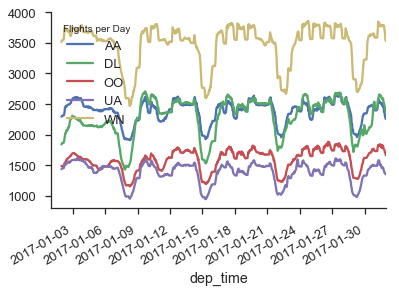

In [10]:
(df.dropna(subset=['dep_time', 'unique_carrier'])
   .loc[df['unique_carrier']
       .isin(df['unique_carrier'].value_counts().index[:5])]
   .set_index('dep_time')
   # TimeGrouper to resample & groupby at once
   .groupby(['unique_carrier', pd.TimeGrouper("H")])
   .fl_num.count()
   .unstack(0)
   .fillna(0)
   .rolling(24)
   .sum()
   .rename_axis("Flights per Day", axis=1)
   .plot()
)
sns.despine()

In [12]:
import statsmodels.api as sm

Does a plane with multiple flights on the same day get backed up, causing later flights to be delayed more?

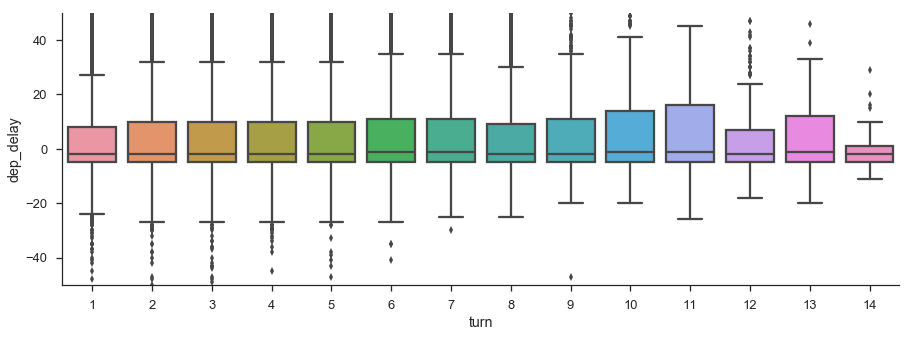

In [13]:
%config InlineBackend.figure_format = 'png'
flights = (df[['fl_date', 'tail_num', 'dep_time', 'dep_delay']]
           .dropna()
           .sort_values('dep_time')
           .loc[lambda x: x.dep_delay < 500]
           .assign(turn = lambda x:
                x.groupby(['fl_date', 'tail_num'])
                 .dep_time
                 .transform('rank').astype(int)))

fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x='turn', y='dep_delay', data=flights, ax=ax)
ax.set_ylim(-50, 50)
sns.despine()

Doesn't really look like it. Maybe other planes are swapped in when one gets delayed, but we don't have data on scheduled flights per plane.
Do flights later in the day have longer delays?

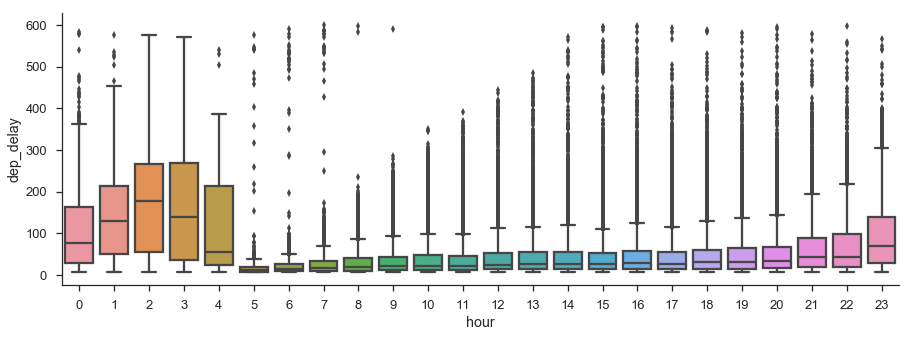

In [14]:
plt.figure(figsize=(15, 5))
(df[['fl_date', 'tail_num', 'dep_time', 'dep_delay']]
    .dropna()
    .assign(hour=lambda x: x.dep_time.dt.hour)
    .query('5 < dep_delay < 600')
    .pipe((sns.boxplot, 'data'), 'hour', 'dep_delay'))
sns.despine()

There could be something here. I didn't show it here since I filtered them out, but the vast majority of flights do leave on time.

Thanks for reading! This section was a bit more abstract, since we were talking about styles of coding rather than how to actually accomplish tasks. I'm sometimes guilty of putting too much work into making my data wrangling code look nice and feel correct, at the expense of actually analyzing the data. This isn't a competition to have the best or cleanest pandas code; pandas is always just a means to the end that is your research or business problem. Thanks for indulging me.

Next time we'll talk about a much more practical topic: performance.